In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from scipy.optimize import minimize
import pickle

import warnings
warnings.filterwarnings('ignore') # 경고 메세지 OFF

#### 각 크립토 시장 데이터 불러오기

In [2]:
BTC = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/비트코인 과거 데이터.csv")
ETH = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/이더리움 과거 데이터.csv")
BNB = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/BNB 과거 데이터.csv")
DOT = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/Polkadot 과거 데이터.csv")
SOL = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/Solana 과거 데이터.csv")
FTT = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/FTX Token 과거 데이터.csv")
XRP = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/XRP 과거 데이터.csv")
UNI = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/Uniswap 과거 데이터.csv")

#### Q(투자자 기대 수익률) 불러오기

In [4]:
# Q 벡터를 pickle 파일에서 불러오기
with open('q_vector_epoch_price_log.pkl', 'rb') as f:
    Q = pickle.load(f)

dates = pd.date_range(start='2023-06-01', end='2023-12-31')
# Q 딕셔너리를 DataFrame으로 변환
Q_df = pd.DataFrame.from_dict(Q, orient='index', columns=dates)

# [[]] 구조를 제거하고 단일 값으로 변환
for col in Q_df.columns:
    Q_df[col] = Q_df[col].apply(lambda x: x[0][0] if isinstance(x, list) and len(x) > 0 and isinstance(x[0], list) and len(x[0]) > 0 else x)

Q_df

,2023-06-01,2023-06-02,2023-06-03,2023-06-04,2023-06-05,2023-06-06,2023-06-07,2023-06-08,2023-06-09,2023-06-10,...,2023-12-22,2023-12-23,2023-12-24,2023-12-25,2023-12-26,2023-12-27,2023-12-28,2023-12-29,2023-12-30,2023-12-31
BTC,10.252285,10.252207,10.251546,10.247274,10.239696,10.243975,10.252417,10.253454,10.247150,10.244048,...,10.684467,10.679665,10.667463,10.663246,10.664358,10.666962,10.661461,10.656079,10.648870,10.644415
ETH,7.493035,7.493018,7.493380,7.490542,7.486649,7.490130,7.496673,7.497606,7.494807,7.490487,...,7.733665,7.748577,7.742535,7.751028,7.730189,7.743311,7.763931,7.752651,7.753211,7.745975
BNB,5.506968,5.505818,5.507248,5.504807,5.504110,5.500242,5.498849,5.502224,5.502012,5.503606,...,5.651052,5.632554,5.593020,5.630453,5.652219,5.765078,5.798089,5.819987,5.789907,5.757491
DOT,1.761833,1.765159,1.767950,1.765393,1.771650,1.779781,1.778653,1.764028,1.746088,1.733700,...,2.225985,2.271722,2.243629,2.338364,2.318960,2.315391,2.292042,2.288853,2.265112,2.235220
SOL,2.982795,2.976762,2.978995,2.975202,2.987130,2.990943,2.988311,2.970966,2.950715,2.930219,...,4.536908,4.605495,4.652257,4.683587,4.650049,4.616191,4.513321,4.567031,4.531306,4.510063
FTT,0.650335,0.652293,0.649100,0.634531,0.645922,0.654925,0.655142,0.657704,0.697897,0.703432,...,1.478625,1.470064,1.472347,1.472374,1.461775,1.459082,1.452703,1.438390,1.427573,1.448277
XRP,0.458232,0.453339,0.452522,0.443780,0.447630,0.459930,0.459474,0.460016,0.452885,0.456265,...,0.497495,0.490629,0.491290,0.495512,0.487266,0.494255,0.493434,0.492935,0.502005,0.491073
UNI,1.820125,1.822981,1.822693,1.831663,1.820482,1.815065,1.812175,1.795620,1.794833,1.789834,...,2.039968,2.048886,2.038353,2.050991,2.028806,2.044627,2.043871,2.076361,2.061864,2.056471


In [5]:
# 날짜 범위 정의
start_date = pd.to_datetime('2023-06-01')
end_date = pd.to_datetime('2023-12-31')

# 데이터프레임과 티커 이름을 매핑
ticker_dfs = {'BTC':BTC, 'ETH': ETH, 'BNB': BNB, 'DOT': DOT, 'SOL': SOL, 'FTT': FTT, 'XRP':XRP,'UNI':UNI}

# 각 데이터프레임을 처리하고 결과를 저장
filtered_dfs = {}
for ticker, df in ticker_dfs.items():
    # 필요없는 열 삭제
    
    del df['고가']
    del df['시가']
    del df['저가']
    del df['거래량']
    del df['변동 %']
    # 날짜 열을 datetime 객체로 변환
    df['created_at'] = pd.to_datetime(df['날짜'])
    del df['날짜']
    if not pd.api.types.is_string_dtype(df['종가']):
        df['종가'] = df['종가'].astype(str)

    # 문자열에서 쉼표 제거 후 float 타입으로 변환
    df['종가'] = df['종가'].str.replace(',', '').astype(float)
    # 주어진 날짜 범위에 맞게 필터링
    filtered_df2 = df[(df['created_at'] >= start_date) & (df['created_at'] <= end_date)]
    filtered_df2.reset_index(drop=True, inplace=True)

    # 필터링된 데이터프레임을 딕셔너리에 저장
    filtered_dfs[ticker] = filtered_df2

In [6]:
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
returns = pd.DataFrame(index=all_dates)

for ticker, df in filtered_dfs.items():
    df.set_index('created_at', inplace=True)  # 'created_at'을 인덱스로 설정
    df = df.reindex(all_dates)  # 모든 날짜에 대해 데이터프레임을 재정렬
    
    # '변동 %' 데이터를 100으로 나누고 로그 변환 적용
    
    df['종가'] = np.log1p(df['종가'])  # 로그 변환 적용

    returns[ticker] = df['종가']

# 반환된 데이터프레임 확인
print(returns)

                  BTC       ETH       BNB       DOT       SOL       FTT  \
2023-06-01  10.196903  7.529820  5.722931  1.825678  3.067913  0.659177   
2023-06-02  10.212651  7.553863  5.731073  1.837051  3.102701  0.678084   
2023-06-03  10.206292  7.545945  5.728800  1.846721  3.099642  0.659228   
2023-06-04  10.208148  7.544882  5.723912  1.843086  3.128075  0.675594   
2023-06-05  10.156128  7.502297  5.627981  1.802864  3.044522  0.624868   
...               ...       ...       ...       ...       ...       ...   
2023-12-27  10.679309  7.774700  5.783794  2.271094  4.680111  1.477825   
2023-12-28  10.659189  7.760241  5.780126  2.243684  4.633223  1.414493   
2023-12-29  10.647171  7.740769  5.751302  2.229046  4.674379  1.382889   
2023-12-30  10.648698  7.737485  5.760793  2.234734  4.632863  1.481514   
2023-12-31  10.651916  7.733202  5.746203  2.219638  4.630740  1.403299   

                 XRP       UNI  
2023-06-01  0.409782  1.788755  
2023-06-02  0.421778  1.803013  


#### RMSE & MAE 계산

In [7]:
transposed_returns = returns.transpose()
transposed_returns

,2023-06-01,2023-06-02,2023-06-03,2023-06-04,2023-06-05,2023-06-06,2023-06-07,2023-06-08,2023-06-09,2023-06-10,...,2023-12-22,2023-12-23,2023-12-24,2023-12-25,2023-12-26,2023-12-27,2023-12-28,2023-12-29,2023-12-30,2023-12-31
BTC,10.196903,10.212651,10.206292,10.208148,10.156128,10.212119,10.178977,10.184979,10.184156,10.159872,...,10.691261,10.685364,10.668548,10.682342,10.657596,10.679309,10.659189,10.647171,10.648698,10.651916
ETH,7.529820,7.553863,7.545945,7.544882,7.502297,7.541773,7.513764,7.521145,7.518287,7.468833,...,7.751574,7.744834,7.725140,7.728583,7.710537,7.774700,7.760241,7.740769,7.737485,7.733202
BNB,5.722931,5.731073,5.728800,5.723912,5.627981,5.642297,5.561489,5.571812,5.566473,5.479388,...,5.605434,5.605067,5.581238,5.590240,5.699774,5.783794,5.780126,5.751302,5.760793,5.746203
DOT,1.825678,1.837051,1.846721,1.843086,1.802864,1.825033,1.795419,1.795585,1.788421,1.708015,...,2.191989,2.234306,2.263324,2.321407,2.283504,2.271094,2.243684,2.229046,2.234734,2.219638
SOL,3.067913,3.102701,3.099642,3.128075,3.044522,3.062924,2.976906,2.990318,2.912242,2.810787,...,4.594837,4.690871,4.731547,4.802060,4.732710,4.680111,4.633223,4.674379,4.632863,4.630740
FTT,0.659177,0.678084,0.659228,0.675594,0.624868,0.637212,0.645584,0.739744,0.665313,0.602621,...,1.527425,1.545859,1.550070,1.537727,1.493556,1.477825,1.414493,1.382889,1.481514,1.403299
XRP,0.409782,0.421778,0.417921,0.429058,0.411421,0.425196,0.417578,0.421188,0.430476,0.410001,...,0.485077,0.482130,0.477488,0.498391,0.483635,0.491257,0.491343,0.484252,0.482877,0.479589
UNI,1.788755,1.803013,1.805975,1.794240,1.745017,1.753019,1.714500,1.728127,1.719905,1.622552,...,2.000128,1.992930,2.059303,2.075270,2.121902,2.108660,2.175876,2.147754,2.123351,2.106789


In [8]:
# 티커별로 오차 계산
tickers = ['BTC', 'ETH', 'BNB', 'DOT', 'SOL', 'FTT', 'XRP', 'UNI']
for ticker in tickers:
    expected_returns = Q_df.loc[ticker]
    actual_returns = transposed_returns.loc[ticker]

    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(actual_returns, expected_returns))
    print(f"{ticker} RMSE: {rmse}")

    # MAE 계산
    mae = mean_absolute_error(actual_returns, expected_returns)
    print(f"{ticker} MAE: {mae}")

BTC RMSE: 0.046808868687263014
BTC MAE: 0.03728379153718353
ETH RMSE: 0.05948724193823778
ETH MAE: 0.05020180230514143
BNB RMSE: 0.05205799018529447
BNB MAE: 0.035148703020154666
DOT RMSE: 0.0506400117933458
DOT MAE: 0.04045759807327638
SOL RMSE: 0.10579091518081542
SOL MAE: 0.09261706921972342
FTT RMSE: 0.06029530725981048
FTT MAE: 0.044753362211054
XRP RMSE: 0.03829124785202783
XRP MAE: 0.029200261204186343
UNI RMSE: 0.05064959030631669
UNI MAE: 0.04201574138736706


#### R2 & MAPE 값 추가

In [9]:
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 결과를 저장하기 위한 딕셔너리
results = {}

for ticker in tickers:
    expected_returns = Q_df.loc[ticker]
    actual_returns = transposed_returns.loc[ticker]
    
    # 오차 지표 계산
    rmse = np.sqrt(mean_squared_error(actual_returns, expected_returns))
    mae = mean_absolute_error(actual_returns, expected_returns)
    mape = calculate_mape(actual_returns, expected_returns)
    r_squared = r2_score(actual_returns, expected_returns)

    # 결과 저장
    results[ticker] = {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r_squared}

# 결과 출력
for ticker, metrics in results.items():
    print(f"{ticker}:")
    print(f"  RMSE: {metrics['RMSE']:.2f}")
    print(f"  MAE: {metrics['MAE']:.2f}")
    print(f"  MAPE: {metrics['MAPE']:.2f}%")
    print(f"  R2: {metrics['R2']:.2f}")
    print("------")


BTC:
  RMSE: 0.05
  MAE: 0.04
  MAPE: 0.36%
  R2: 0.92
------
ETH:
  RMSE: 0.06
  MAE: 0.05
  MAPE: 0.67%
  R2: 0.72
------
BNB:
  RMSE: 0.05
  MAE: 0.04
  MAPE: 0.64%
  R2: 0.67
------
DOT:
  RMSE: 0.05
  MAE: 0.04
  MAPE: 2.24%
  R2: 0.91
------
SOL:
  RMSE: 0.11
  MAE: 0.09
  MAPE: 2.77%
  R2: 0.96
------
FTT:
  RMSE: 0.06
  MAE: 0.04
  MAPE: 4.81%
  R2: 0.97
------
XRP:
  RMSE: 0.04
  MAE: 0.03
  MAPE: 6.58%
  R2: 0.44
------
UNI:
  RMSE: 0.05
  MAE: 0.04
  MAPE: 2.36%
  R2: 0.87
------


In [10]:
# 결과를 저장할 딕셔너리
results = {}
transformed_market_data = pd.DataFrame()

for ticker in tickers:
    expected_returns = Q_df.loc[ticker]
    actual_returns = transposed_returns.loc[ticker]

    transformed_market_data[ticker] = transposed_returns.loc[ticker]

    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(actual_returns, expected_returns))

    # MAE 계산
    mae = mean_absolute_error(actual_returns, expected_returns)

    # R2 계산
    r_squared = r2_score(actual_returns, expected_returns)

    # MAPE 계산
    mape = calculate_mape(actual_returns, expected_returns)

    # 결과 저장
    results[ticker] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r_squared,
        'MAPE': mape
        }

#### 그래프 비교

In [11]:
transformed_market_data = transformed_market_data.transpose()

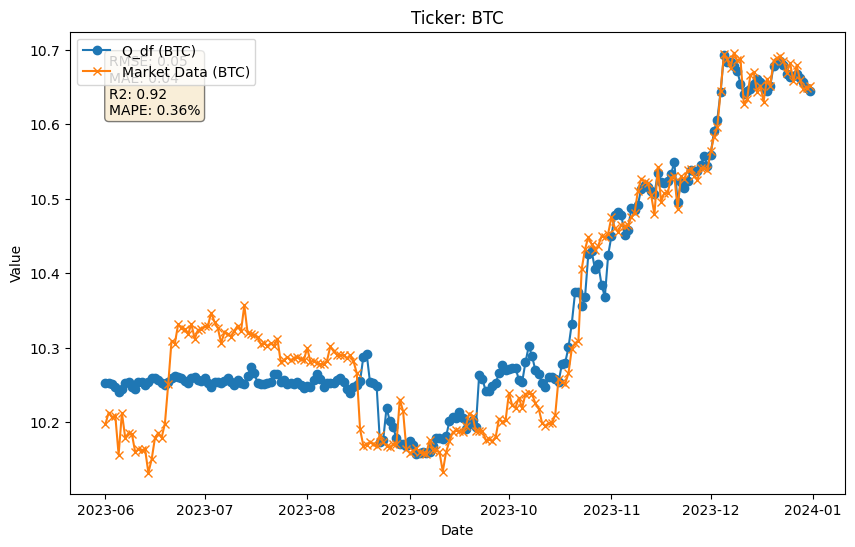

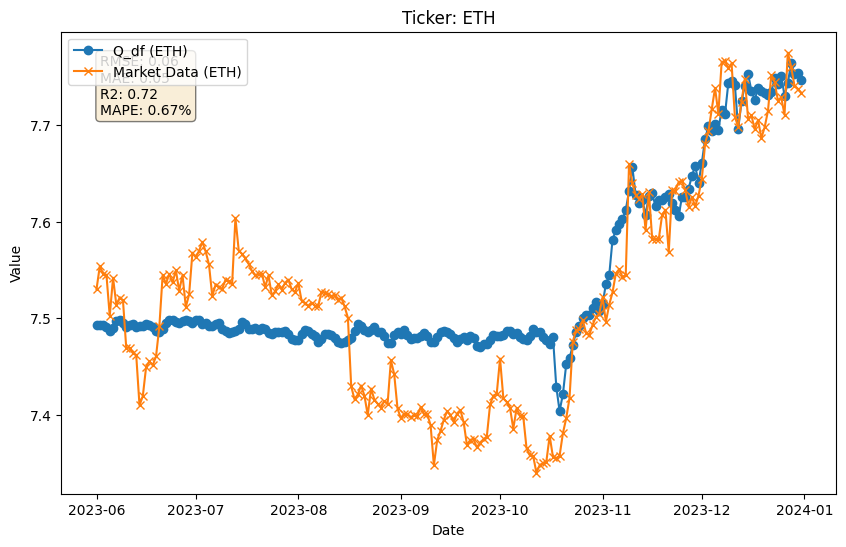

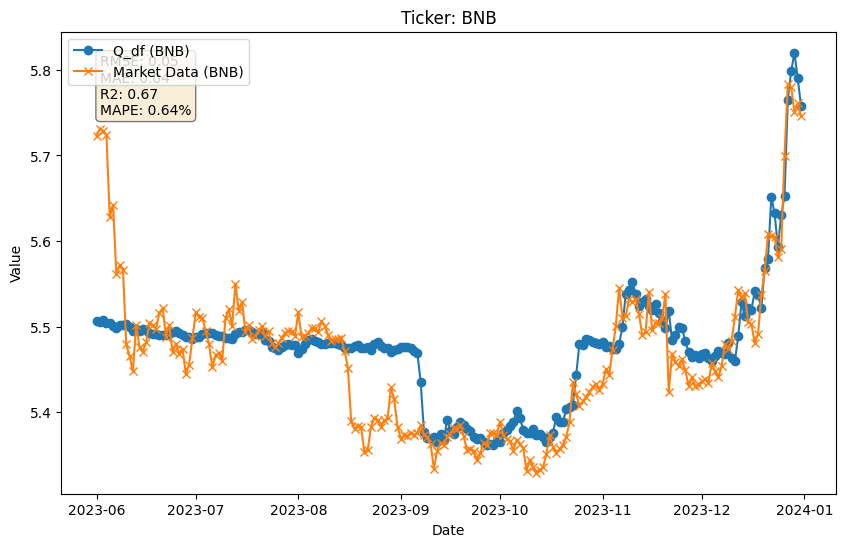

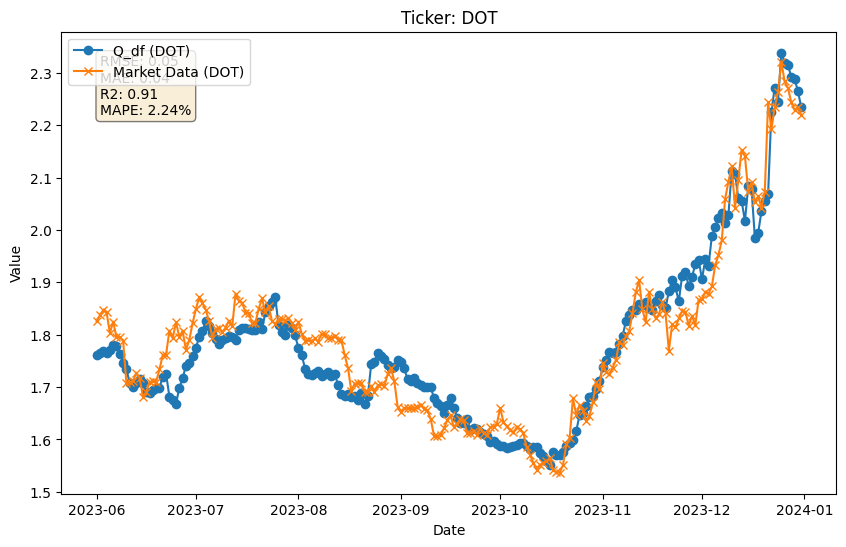

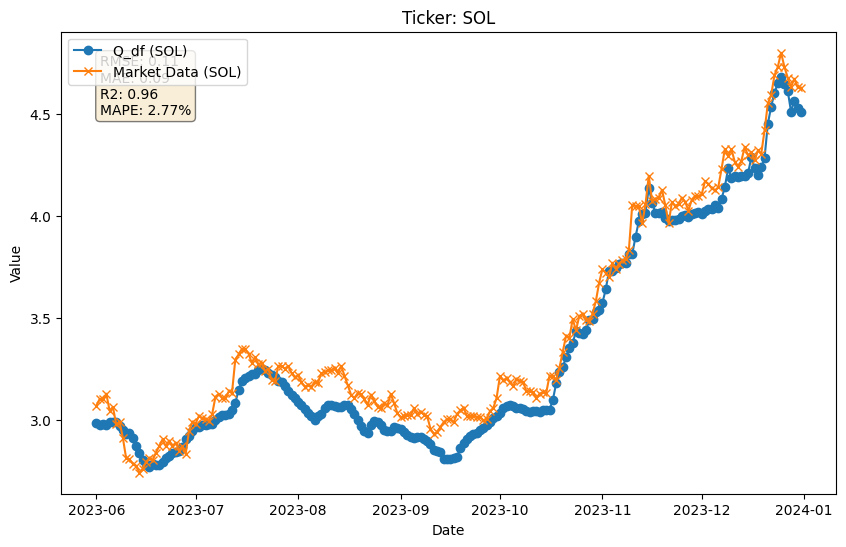

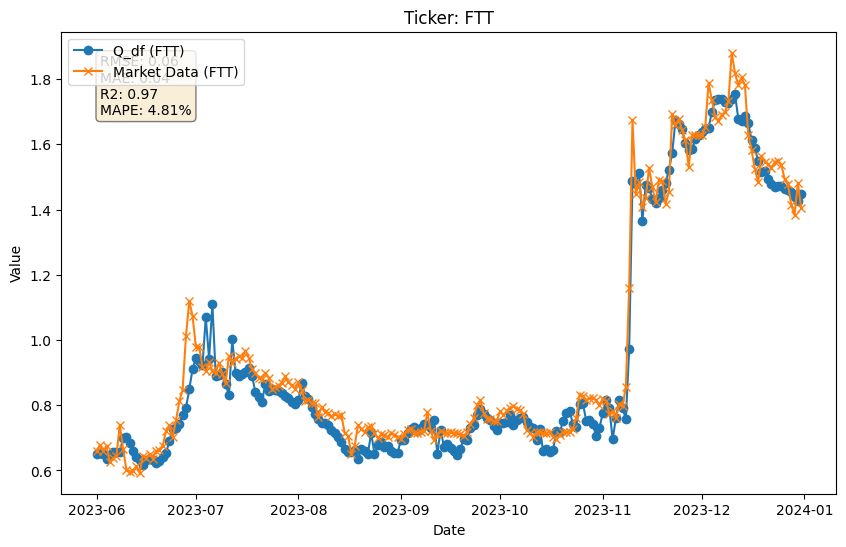

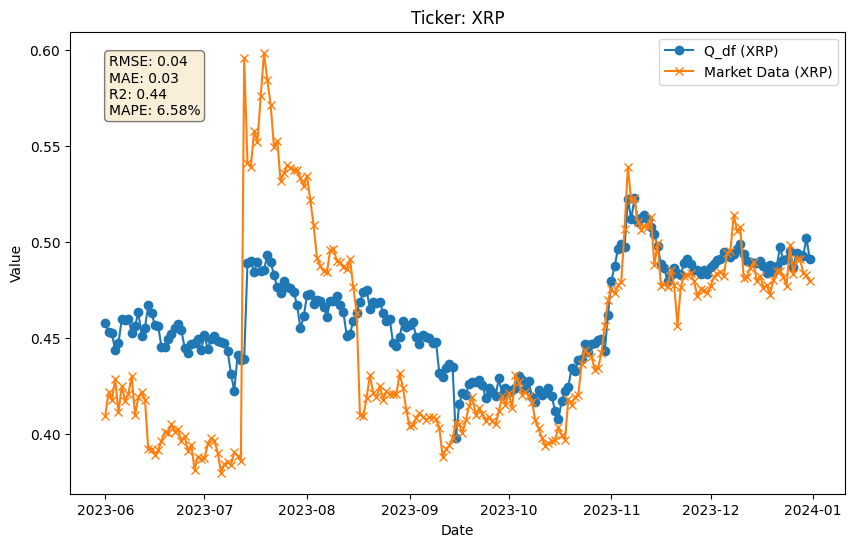

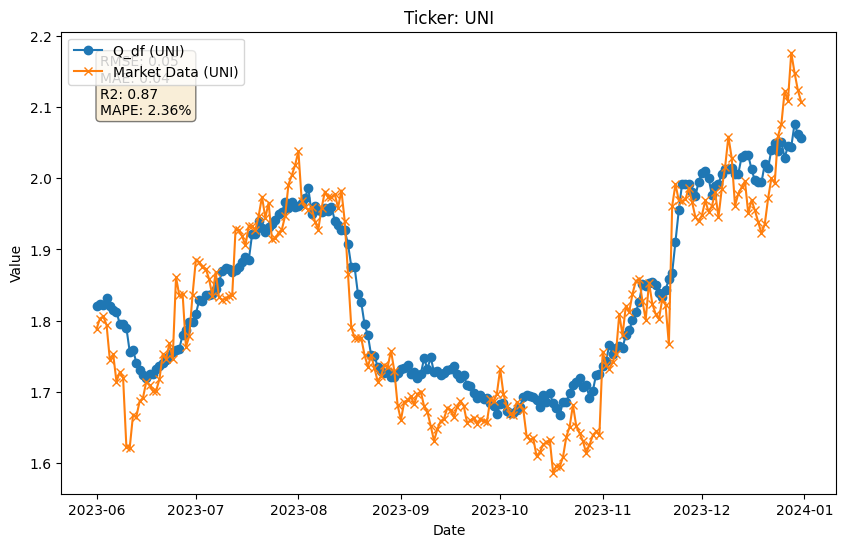

In [12]:
for ticker in tickers:
    fig, ax = plt.subplots(figsize=(10, 6))

    # Q_df와 시장 데이터 플롯
    ax.plot(Q_df.loc[ticker].index, Q_df.loc[ticker], label=f'Q_df ({ticker})', marker='o')
    ax.plot(transformed_market_data.loc[ticker].index, transformed_market_data.loc[ticker], label=f'Market Data ({ticker})', marker='x')

    # 오차 지표 추가
    metrics = results[ticker]
    textstr = '\n'.join((
        f'RMSE: {metrics["RMSE"]:.2f}',
        f'MAE: {metrics["MAE"]:.2f}',
        f'R2: {metrics["R2"]:.2f}',
        f'MAPE: {metrics["MAPE"]:.2f}%'))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

    # 그래프 설정
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.set_title(f'Ticker: {ticker}')
    ax.legend()
    plt.show()